# CHALLENGE 3
## Doing randomized benchmarking for Belem and Quito
- We are trying to do randomly generate gates and then apply their inverses to the same circuit
- If the message at the end of measurement is same with high probability, the gates in that quantum computer have a high fidelity

In [6]:
from qiskit import * 
import matplotlib.pyplot as plt 
from qiskit.tools.jupyter import backend_overview
from qiskit import IBMQ 
provider= IBMQ.load_account()
%matplotlib inline 

E:\ANACONDA\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-04-22 12:34:44,760: Credentials are already in use. The existing account in the session will be replaced.


In [68]:
%qiskit_backend_overview

- We need to have an idea of the **noise model** of the actual quantum computer and thus we need to have the NoiseModel class as a noise configuration that we provide to our simulator

### 1. Making Noise models

In [ ]:
import qiskit.ignis.verification.randomized_benchmarking as rb 
from qiskit.providers.aer.noise import NoiseModel

In [8]:
belem = provider.get_backend('ibmq_belem')
quito = provider.get_backend('ibmq_quito')

In [9]:
belem_noise = NoiseModel.from_backend(backend=belem)
quito_noise = NoiseModel.from_backend(backend=quito)

In [10]:
print("Belem Noise model :\n",belem_noise)

Belem Noise model :
 NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'measure', 'x', 'reset', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [1, 2]), ('cx', [1, 0]), ('cx', [0, 1]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [11]:
print("Quito noise model :\n",quito_noise)

Quito noise model :
 NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'measure', 'x', 'reset', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [1, 3]), ('cx', [3, 1]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


### 2. Create a 4 qubit circuit with random gates

In [53]:
#circuit lengths
lengths = [i**2 for i in range(1,15)]

# qubits
pattern = [[i for i in range(4)]]

RAND_CIRCS, _ = rb.randomized_benchmarking_seq(length_vector=lengths,rb_pattern=pattern)

- Testing the circuit : we have 10 circuits from varying lengths and we wish to test them on quito and belem
- Again, RAND_CIRCS is a 2-D array as we can ask qiskit to generate n different trial circuits each consisting of 10 different length circuits

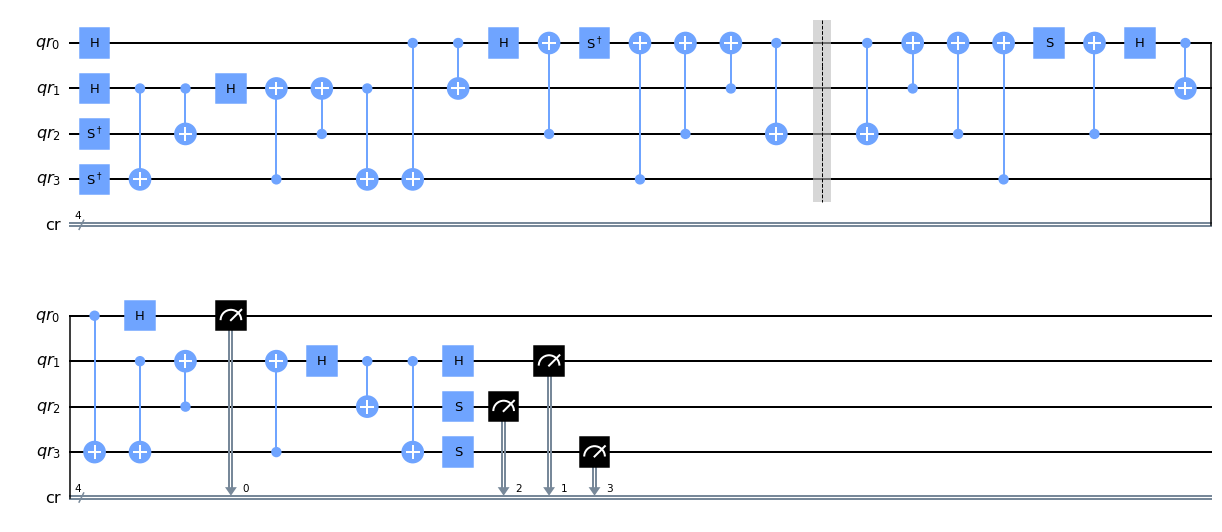

In [27]:
RAND_CIRCS[0][0].draw('mpl')

### 3. Testing circuits for quito and belem

In [54]:
belem_result = np.zeros(14)
quito_result = np.zeros(14)

shots = 2**16 
backend = Aer.get_backend('qasm_simulator')
for i in range(14):
    circ = RAND_CIRCS[0][i]
    
    # simulate on belem 
    job1 = execute(circ, backend=backend , noise_model = belem_noise,shots = shots)
    res1 = job1.result()
    count1 = res1.get_counts()["0000"]
    
    belem_result[i] = count1 
    
    # simulate on quito 
    job2 = execute(circ, backend = backend, noise_model = quito_noise, shots=shots)
    res2 = job2.result()
    count2 = res2.get_counts()["0000"]
    
    quito_result[i] = count2 
    print("For length",lengths[i],"done...")


For length 1 done...
For length 4 done...
For length 9 done...
For length 16 done...
For length 25 done...
For length 36 done...
For length 49 done...
For length 64 done...
For length 81 done...
For length 100 done...
For length 121 done...
For length 144 done...
For length 169 done...
For length 196 done...


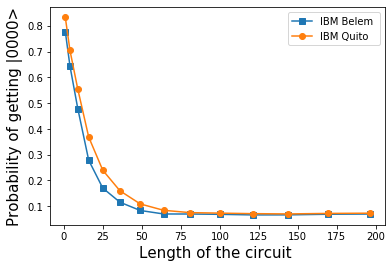

In [55]:
plt.plot(lengths, belem_result / shots , label = "IBM Belem ",marker = 's')
plt.plot(lengths, quito_result / shots , label = "IBM Quito",marker = 'o')
plt.legend()
plt.xlabel("Length of the circuit ",fontsize = 15)
plt.ylabel("Probability of getting |0000>",fontsize = 15)
plt.show()

- Again, as expected **quito is better**

- **NOTE**
: the probability of success *does not diminish further than 0.1* 
: This is because even in extremely noisy environments, there is going to be some random of getting 0000

## Fitting curves to the BELEM plots

In [30]:
import numpy as np 

In [61]:
x = lengths 
y1 = belem_result / shots 
y2 = quito_result / shots

- Fitting of the form 
$$ y = Ae^{Bx} $$

In [65]:
c1 = np.polyfit(x,np.log(y1), 1, w= np.sqrt(y1))
a1 = np.exp(c1[1]) 
b1 = c1[0]
print("Parameters A :",a1,"B:",b1)

Parameters A : 0.5397196383572453 B: -0.016134421054729512


In [66]:
samples = np.linspace(0,200,200)
actual_curve_belem = [a1*np.exp(b1*i) for i in samples]

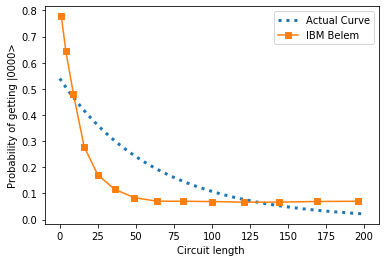

In [67]:
plt.plot(samples,actual_curve_belem,label = "Actual Curve",linestyle = 'dotted',linewidth = 3)
plt.plot(lengths, belem_result / shots , label = "IBM Belem ",marker = 's')
plt.legend()
plt.xlabel("Circuit length ")
plt.ylabel("Probability of getting |0000>")
plt.show()